The Multi-Armed Bandit (MAB) is a problem where an agent chooses among several options (arms), each with an unknown reward distribution, with the goal of maximizing cumulative reward over time. There are several ways to solve this problem, including Epsilon Greedy and Upper Confidence Bound (UCB). Let’s go through both:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Defining the distributions
class Arms:
    def __init__(self, type, param1, param2):
        self.type = type
        self.param1 = param1
        self.param2 = param2


    def get_reward(self):
        if self.type == 'uniform':
            return np.random.uniform(self.param1, self.param2)
        if self.type == 'gaussian':
            return np.random.normal(self.param1, self.param2)
        if self.type == 'exponential':
            return np.random.exponential(1.0 / self.param1)
        if self.type == 'beta':
            return np.random.beta(self.param1, self.param2)


In [2]:
np.random.seed(42)
arm1 = Arms('uniform', 5, 10)
arm2 = Arms('gaussian', 6, 2)
arm3 = Arms('exponential', 1/4, 0)
arm4 = Arms('beta', 2, 5)
arm5 = Arms('uniform', -5, 0)
arm6 = Arms('gaussian', 10, 6)
arm7 = Arms('exponential', 1/7, 0)
arm8 = Arms('beta', 5, 2) 

arms = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8]

In epsilon greedy, we define a number epsilon which dictates how often we explore and exploit.  
Eploration consists of choosing a random arm and getting more information whilst exploiting is choosing the arm that you know gives the maximum rewards (based on the information you have so far).

In [3]:
class EpsilonGreedy:
    def __init__(self, arms, epsilon, steps):
        self.arms = arms
        self.epsilon = epsilon
        self.steps = steps
        # TODO: Initialize parameters
        self.estimated_rewards = np.zeros((len(self.arms),)) # Estimated rewards of all arms
        self.action_count = np.zeros((len(self.arms),)) # Number of times arm 'i' is chosen (for all arms)
        self.total_reward = 0
        self.rewards = []
        np.random.seed(42)

    def select_action(self):
        # TODO: Implement epsilon greedy approach of choosing arms here
        if np.random.rand()<self.epsilon:
            action=np.random.choice(np.arange(len(self.arms)))
        else:
            action=np.random.choice(np.arange(len(self.arms))[self.estimated_rewards==np.max(self.estimated_rewards)])
        # Return action chosen (which arm to pick)
        return action
        

    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here
        self.rewards+=[reward,]
        self.total_reward+=reward
        self.action_count[action]+=1
        self.estimated_rewards[action]+=(reward-self.estimated_rewards[action])/(self.action_count[action])
        

    def run(self):
        for _ in range(self.steps):
            action = self.select_action()
            reward = self.arms[action].get_reward()
            self.update(action, reward)
            self.epsilon*=0.995

        return self.total_reward, self.estimated_rewards, self.rewards

Total reward: 10362.58835504137
Estimated means: [ 7.66143565  5.15460622  1.27061446  0.28231903 -3.28573883 10.560771
  2.72978936  0.76048581]


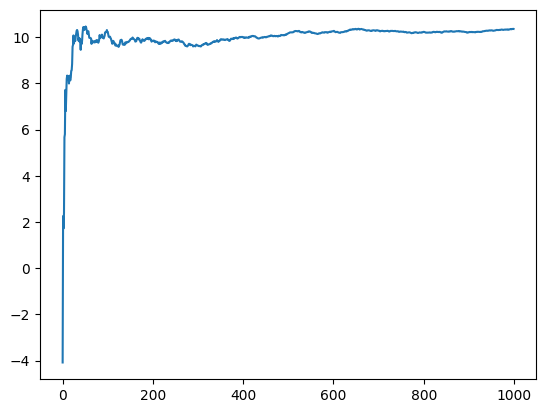

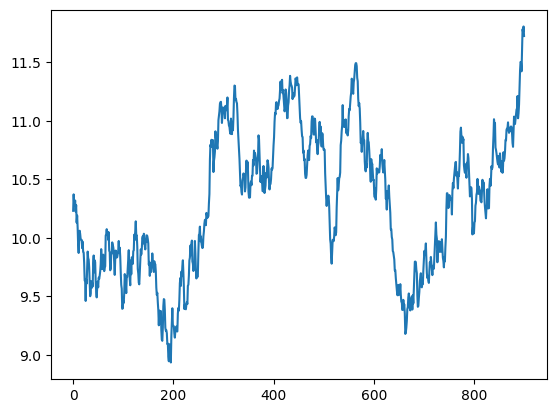

In [4]:
steps = 1000
epsilon = 0.15 # Play around with this value

banditEG = EpsilonGreedy(arms, epsilon , steps)
total_reward, estimated_rewards, rewards = banditEG.run()
print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_rewards}")
# TODO: Plot average rewards over time (use np.cumsum)
plt.plot(np.cumsum(rewards)/(np.arange(1,np.cumsum(rewards).size+1)))
plt.show()
plt.plot(np.convolve(rewards,np.ones((100,))*0.01,mode="valid"))
plt.show()


In upper confidence bound, we have the upper confidence estimate where we use both the estimated mean and the number of times we have picked that option. The more times you have chosen something, the more certain you are of its estimated mean. Using this we have 2 terms, the estimated mean and the confidence score. The constant c dictates how much the confidence score affects our choice.

$UCB_t(a) = \hat{Q}_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}}$  
$\hat{Q}_t(a)$ is the estimated reward. $N_t(a)$ is the number of times arm $a$ has been picked and $t$ is the timestamp

In [5]:
class UpperConfidenceBound:
    def __init__(self, arms, steps, c):
        self.arms = arms
        self.steps = steps
        self.c = c
        # TODO: Initialize parameters
        self.estimated_rewards = np.zeros((len(self.arms),)) # Estimated rewards of all arms
        self.action_count = np.zeros((len(self.arms),)) # Number of times arm 'i' is chosen (for all arms)
        self.total_reward = 0
        self.rewards = []

    def select_action(self, t):
        # TODO: First, play each arm at least once.
        for idx in np.arange(len(self.arms)):
            if self.action_count[idx]==0 :
                return idx
        # Compute the UCB values for each arm and choose accordingly
        UCB=self.estimated_rewards+self.c*(np.sqrt(np.log(t)/self.action_count))
        action = np.argmax(UCB)
        return action
    
    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here
        self.total_reward+=reward
        self.rewards+=[reward,]
        self.action_count[action]+=1
        self.estimated_rewards[action]+=(reward-self.estimated_rewards[action])*(1/(self.action_count[action]))        

    def run(self):
        for t in range(self.steps):
            action = self.select_action(t)
            reward = self.arms[action].get_reward()
            self.update(action, reward)
            #Decay Value of C
            self.c*=0.9995
        return self.total_reward, self.estimated_rewards, self.rewards

Total reward: 10034.386751829457
Estimated means: [ 7.73828618  3.35995498  0.18689394  0.26055355 -2.58979471 10.10745648
  2.306174    0.63542578]


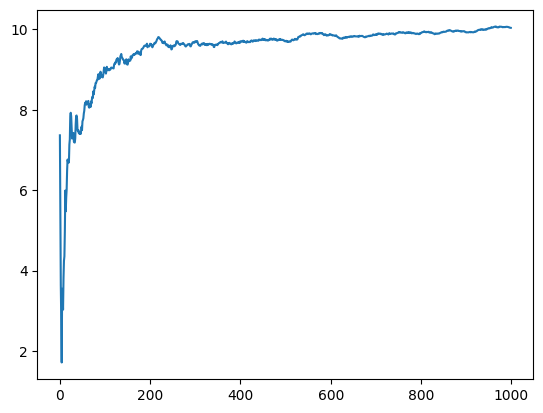

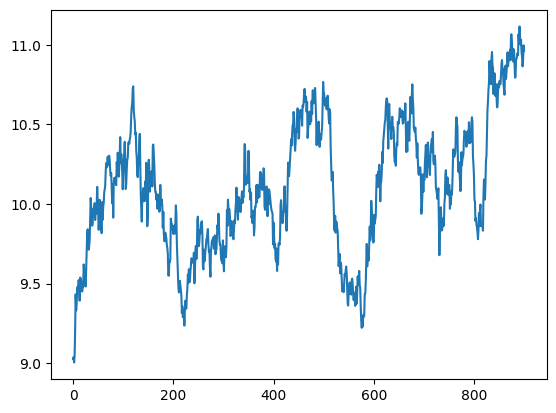

In [6]:
steps = 1000
c = 1.4 # Play around with this value

banditUCB = UpperConfidenceBound(arms, steps, c)
total_reward, estimated_reward, rewards = banditUCB.run()
print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_reward}")

# TODO: Plot average rewards over time (use np.cumsum)
plt.plot(np.cumsum(rewards)/(np.arange(1,np.cumsum(rewards).size+1)))
plt.show()
#To know the estimated value as the learning proceeds
plt.plot(np.convolve(rewards,np.ones((100,))*0.01,mode="valid"))
plt.show()


## Optional challenges

1. if you already know the distribution the arms draw from(eg: gaussian), can you incorporate that knowledge to learn faster

We will host a competition where we will run your agents and host a leaderboard(details in the next meet)

In [7]:
#Q-Learning on Multi Arm Bandits
class q_learning:
    def __init__(self, arms, steps,epsilon,alpha,alpha_decay=0,epsilon_decay=1):
        self.arms = arms
        self.steps = steps
        self.alpha = alpha
        self.alpha_decay=alpha_decay
        self.epsilon_decay=epsilon_decay
        self.epsilon=epsilon
        # TODO: Initialize parameters
        self.q_values=np.zeros((len(self.arms),))
        self.total_reward=0
        self.rewards=[]
        
    def select_action(self, t):
        # TODO: First, play each arm at least once.
        if np.random.rand()<self.epsilon:
            action=np.random.choice(np.arange(len(self.arms)))
        else:
            action=np.random.choice(np.arange(len(self.arms))[self.q_values==np.max(self.q_values)])
            
        return action
    
    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here
        self.q_values[action]+=self.alpha*(reward-self.q_values[action])/(1+self.alpha_decay*(len(self.rewards)))
        self.total_reward+=reward
        self.rewards+=[reward,]
           

    def run(self):
        for t in range(self.steps):
            action = self.select_action(t)
            reward = self.arms[action].get_reward()
            self.update(action, reward)
            self.epsilon*=self.epsilon_decay
        return self.total_reward, self.q_values, self.rewards

Total reward: 8575.684658346381
Q-Values : [ 6.78667582  5.16296861  4.66332666  0.30881593 -2.32954828 10.54349661
  7.99453316  0.59034891]


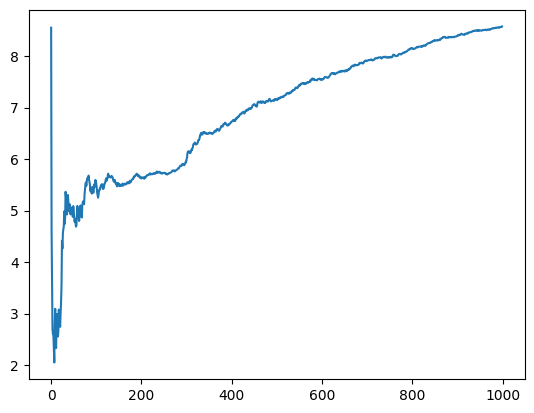

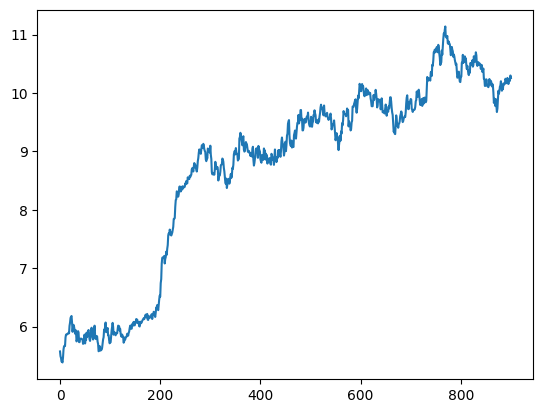

In [8]:
steps=1000
epsilon=1
epsilon_decay=0.995
alpha=0.5
alpha_decay=0.01
QLearn = q_learning(arms, steps, epsilon=epsilon,epsilon_decay=epsilon_decay,alpha=alpha,alpha_decay=alpha_decay)
total_reward, q_values, rewards = QLearn.run()
print(f"Total reward: {total_reward}")
print(f"Q-Values : {q_values}")
plt.plot(np.cumsum(rewards)/(np.arange(1,np.cumsum(rewards).size+1)))
plt.show()
plt.plot(np.convolve(rewards,np.ones((100,))*0.01,mode="valid"))
plt.show()


In [9]:
#The convergence rate in Q learning is slow as compared to epsilon greedy method because the estimated average of arms is ca;culated indirectly over 
# many iterations but in epsilon greedy method it is calculated directly on ach iteration